# 内容提要
- 数据处理的一般流程
- 线性回归: 原理与`sklearn`调用
- 参数惩罚与模型正则化

# 数据处理的一般流程

$\quad$监督学习的一般场景是, 给定训练数据集$\mathcal{D} = \{(\mathbf{x}^{(n)}, t^{(n)})\}_{n=1}^N$与模型函数$y(\mathbf{x};\mathbf{w})$, 通过损失函数$\mathcal{L}$的数值优化来确定参数取值(此为模型的**训练**), 即
$$
\mathbf{w}^* = \arg{\min_{\mathbf{w} \in \mathcal{W}}{\mathcal{L}(\mathbf{w};\mathcal{D})}}.
$$
常见的损失函数包括: 均方误差MSE(用于回归问题), 交叉熵CE(用于分类问题), ...

$\quad$本节将按照机器学习中一般意义下的数据处理流程, 简要介绍如何运用[`pandas`](https://pandas.pydata.org/)库进行(面板)数据的读取与清洗. 具体包括:
- 数据的读取与`DataFrame`类;
- 数据的初步探索;
- 数据清洗与加工.

$\quad$本节用于示教的数据集为`sklearn`内置的[鸢尾花(iris)数据集](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), 特征包括鸢尾花的花萼(sepal)长度与宽度、花瓣(petal)长度与宽度, 标签则是鸢尾花所属的亚种(共3种: `setosa`, `versicolor`, `virginica`).

## 数据的读取与`DataFrame`类

$\quad$容易看出, 监督学习所用的数据集$\mathcal{D}$往往可以用(特征数据构成的)矩阵与(标签数据构成的)向量来描述.

$\quad$我们首先将鸢尾花数据集加载为[`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)的形式, 这是`pandas`库中用于描述和处理二维数据(常称**面板数据**, panel data)的基本数据结构. 当`load_iris()`函数的参数`as_frame`设置为`True`时,  其返回的数据对象的属性`data`和`target`将为`pandas`库中的`DataFrame`类和[`Series`](https://pandas.pydata.org/docs/reference/api/pandas.Series.html)类(用于描述和处理一维序列数据).

In [1]:
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
X, y_true = data.data, data.target

## 数据的初步探索

$\quad$对给定的数据集可先进行初步探索. 例如, 观察`DataFrame`类的下列属性:

- `shape`: 一般地, 每个样本为一行, 每个特征为一列. 若记样本数为$N$, 特征维数为$M$, 则`shape`将输出的形状为$(N, M)$.
- `columns`: 列. 如果存在列索引(本例是存在的), 则可以观察每一列的名称.

从输出结果可见, 该数据集共有150条样本, 4个特征, 3个类别(且各类别样本数都是50个). `Series`对象内置的[`value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html#pandas-series-value-counts)方法可以根据值进行直方图统计.

In [2]:
# (n_samples, n_columns)
X.shape

(150, 4)

In [3]:
# The features of each data entry
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [4]:
# Number of data entries
y_true.shape

(150,)

In [5]:
# Histogram of labels
y_true.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

$\quad$`DataFrame`类中, 索引(indexing)可以有两种方式: ①[按行、列关键字索引](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html#pandas-dataframe-loc); ②像`numpy`数组那样, [按行标、列标的整数数值索引](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html#pandas-dataframe-iloc). 若每一列有关键字, 还可以直接像字典索引那样索引特定的一列或几列.

In [6]:
# indexing using the (label-based) `loc` method
X.loc[:5, "sepal length (cm)":"sepal width (cm)"]

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
5,5.4,3.9


In [7]:
# indexing using the (integer-based) `iloc` method
X.iloc[:5, :2]

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


In [8]:
# indexing a column using column keys
X["petal width (cm)"]

0      0.2
1      0.2
2      0.2
3      0.2
4      0.2
      ... 
145    2.3
146    1.9
147    2.0
148    2.3
149    1.8
Name: petal width (cm), Length: 150, dtype: float64

In [9]:
# multi-column indexing is also supported
X[["sepal length (cm)", "sepal width (cm)"]]

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
...,...,...
145,6.7,3.0
146,6.3,2.5
147,6.5,3.0
148,6.2,3.4


## 数据清洗与加工

$\quad$对原始数据(raw data)的清洗与整理往往是机器学习工作中最为耗时但也最为重要的一步, 这通常包括[缺失值的处理](https://pandas.pydata.org/docs/user_guide/missing_data.html)、数值的归一化、特征的加工等步骤.

- **缺失值的处理**. 实际问题中, 有的样本可能部分或所有信息是缺失的(在`pandas`中标记为`NaN`, 即not a number).
  - 最为简单粗暴(但也常常有效)的做法是丢弃这些数据, 这由`DataFrame`对象内置的[`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna)方法可以实现;
  - 也可以用特定的值来填补缺失部分, 例如用常值0、用同一列特征的均值等, 这由`DataFrame`对象内置的[`fillna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)方法可以实现.

注意本例没有缺失值, 该环节略去, 只做形式上的演示.

In [10]:
X.dropna()
X.shape

(150, 4)

- **数值的归一化**. 不同类型的数据, 其标度(量纲)的不同很可能引起绝对数值上的巨大差异, 而这显然不是我们希望模型学习到的信息. 一种常用的做法是通过归一化等手段对数据数值进行**重标度**(rescaling), 使其数值范围相近. 本例对`sepal length (cm)`分别演示**均值归一化**(mean normalization)
  $$
  x_n' := \frac{x_n - \mathrm{Mean}_{n=1}^N(x)}{\mathrm{Std}_{n=1}^N(x)},\,n=1,\dots,N
  $$
  和**最小-最大归一化**(min-max normalization)
  $$
  x_n' = \frac{x_n - \min_{n=1}^N{(x)}}{\max_{n=1}^N{(x)} - \min_{n=1}^N{(x)}},\,n=1,\dots,N,
  $$
  并以`value_counts()`方法简要地观察取值分布.
  - 均值归一化后, 数据以0为中心; 最大-最小归一化后, 数据均处于区间$[0, 1]$内.

In [11]:
sep = X["sepal length (cm)"]

In [12]:
sep_mean_scaled = (sep - sep.mean()) / sep.std()
sep_mean_scaled.value_counts(bins=5, sort=False)

(-1.869, -0.994]    32
(-0.994, -0.125]    41
(-0.125, 0.745]     42
(0.745, 1.614]      24
(1.614, 2.484]      11
Name: sepal length (cm), dtype: int64

In [13]:
sep_minmax_scaled = (sep - sep.min()) / (sep.max() - sep.min())
sep_minmax_scaled.value_counts(bins=5, sort=False)

(-0.002, 0.2]    32
(0.2, 0.4]       41
(0.4, 0.6]       42
(0.6, 0.8]       24
(0.8, 1.0]       11
Name: sepal length (cm), dtype: int64

- **特征的加工**. 原始特征(或标签)有时并非是模型学习的最佳选择, 我们完全可以自主地从原始数据出发, 提取和加工新的特征. 例如, 将花瓣的长度、宽度相乘, 给出其外切正方形的面积, 以期对花瓣的特征进行*降维*. 两个序列数据(或一维向量)的逐项乘积(在矩阵代数中称为**Hadamard乘积**)可以直接用运算符`*`表示, 这是`numpy`的数组运算规范.

In [14]:
petal_area = X["petal length (cm)"] * X["petal width (cm)"]
petal_area.value_counts(bins=5, sort=False)

(0.0932, 3.262]    50
(3.262, 6.414]     32
(6.414, 9.566]     29
(9.566, 12.718]    25
(12.718, 15.87]    14
dtype: int64

# 线性回归: 原理与`sklearn`调用
$\quad$作为回归(regression)模型中最简单的一类, **线性回归**(linear regression)模型将拟合一个线性函数

$$
y(\mathbf{x};\mathbf{w}) = \mathbf{w}^\mathrm{T}\mathbf{x} + b = \sum_{j=1}^M{w_jx_j} + b,
$$

并通常以均方误差(MSE)作为损失函数:

$$\begin{aligned}
\mathcal{L}(\mathbf{w};\mathcal{D})
&= \frac{1}{N}\sum_{n=1}^N{(t^{(n)} - y(\mathbf{x}^{(n)};\mathbf{w}))^2}\\
&= \frac{1}{N}\sum_{n=1}^N{(t^{(n)} - \mathbf{w}^\mathrm{T}\mathbf{x} - b)^2}.
\end{aligned}$$

$\quad$线性回归模型是可以解析求解的. 将训练数据$\mathcal{D}$组合成特征矩阵$\mathbf{X} \in \mathbb{R}^{N \times (M+1)}$(包含截距列$\mathbf{1}_M$)与标签向量$\mathbf{t} \in \mathbb{R}^N$, 则解析解写为

$$
\mathbf{w}^* = (\mathbf{X}^\mathrm{T}\mathbf{X})^{-1}\mathbf{X}^\mathrm{T}\mathbf{t}.
$$

不过, 更普适的求解方式是基于梯度的一些数值优化算法, 例如**随机梯度下降**(stochastic gradient descent, SGD).

## 人工合成的数据集

$\quad$本节演示的数据集是一个**人工合成的数据集**(synthetic dataset). 这也许不具有实践价值, 但在解释机器学习模型的工作机制、对模型性能进行初步测试等场景中往往具有更简洁、更深刻的效果. 我们构造三个彼此独立的标准正态变量$x_1, x_2, x_3 \sim \mathcal{N}(0, 4 \sigma^2)$, 并将它们的线性组合加上Gaussian噪声$\epsilon \sim \mathcal{N}(0, \sigma^2)$, 作为标签:

$$
y = x_1 + 2x_2 - x_3 + \epsilon.
$$

以下的代码中, 取$\sigma^2 = 0.1$.

- `numpy`以**随机数生成器**[`np.random.Generator`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator)对不同分布律、不同样本量的随机数进行统一管理. 以较推荐使用的生成器[`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)为例, 调用范例为
```python
from np.random import default_rng
rfloat = default_rng.random()
```

In [15]:
from typing import List, Tuple
import numpy as np
from numpy.random import default_rng, normal

def gen_synthetic_dataset(
    n_samples: int=100,
    coefs: List[float]=[1.0, 2.0, -1.0],
    noise: Tuple[float, float]=(0, 0.1),
    random_seed: int=0,
) -> Tuple[np.array, np.array]:
    """
    Generates a synthetic dataset for linear regression.
    
    Args
    ----
    n_samples: int = 100
        The number of samples in a dataset. Default `100`.
    coefs: List[float] = [1.0, 2.0, -1.0]
        The coefficients of features. Default `[1.0, 2.0, -1.0]`.
    noise: Tuple[float, float] = (0, 0.1)
        The distribution parameter of Gaussian noise, formatted as `(loc, scale)`.
        Default `(0, 0.1)`.
    random_seed: float = 0
        The random seed in `numpy` for reproducibility. Default `0`.
    
    Returns
    -------
    X: np.array
        The feature matrix in shape `(n_samples, n_features)`.
    y_true: np.array
        The label vector in shape `(n_samples,)`.
    """
    n_features = len(coefs)
    loc, scale = noise
    rng = default_rng(random_seed)
    X = rng.normal(loc, 2 * scale, size=(n_samples, n_features))
    y_true = np.dot(X, coefs) + rng.normal(loc, scale, size=n_samples)
    return X, y_true

In [16]:
X, y_true = gen_synthetic_dataset(n_samples=5)
X, y_true

(array([[ 0.02514604, -0.02642097,  0.12808453],
        [ 0.02098002, -0.10713387,  0.07231901],
        [ 0.26080001,  0.18941619, -0.14074705],
        [-0.25308429, -0.12465489,  0.0082652 ],
        [-0.46500615, -0.04375833, -0.24918219]]),
 array([-0.22900717, -0.32003264,  0.74874943, -0.46949622, -0.19908929]))

## `sklearn`库中的模型调用接口

$\quad$在[`sklearn`](https://scikit-learn.org/)中, 所有监督学习模型的调用框架都是统一的, 我们先创建一个模型对象, 并传入训练数据以`fit`方法进行训练, 随后以`predict`方法对输入的新数据(特征)进行预测. 下面以线性回归模型[`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)为例, 我们用一个含100个样本的数据集作为训练数据、再用一个新的含5个样本的新数据集作为测试数据.

$\quad$由于人工数据集本身就是从线性组合给出的, 所以, 可以从测试结果中看到, 模型很容易地捕捉到了人工数据集的内禀规律.

In [17]:
# instantiate a model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [18]:
# train a model using the synthetic training set
X_train, y_true_train = gen_synthetic_dataset()
lr.fit(X_train, y_true_train)

LinearRegression()

In [19]:
# make new predictions
X_test, y_true_test = gen_synthetic_dataset(n_samples=5)
y_pred_test = lr.predict(X_test)
y_true_test, y_pred_test

(array([-0.22900717, -0.32003264,  0.74874943, -0.46949622, -0.19908929]),
 array([-0.16845363, -0.2685234 ,  0.7728131 , -0.50529596, -0.28145073]))

## 将运行结果可视化

我们很容易用[`matplotlib`](https://matplotlib.org/)库将模型在训练集上的表现进行可视化. 以下的代码将生成一张描述模型在一个50样本测试集上预测表现的散点图, 包括如下三个方面的信息:
- 散点, 描述各样本. 横坐标为真实标签, 纵坐标为预测标签.
- 直线$y=x$(以虚线示出). 显然, 散点越靠近这条直线, 表明预测标签离真实标签就越近.
- **决定系数**(coefficient of determination)
  $$
  R^2(\mathbf{t}, \mathbf{y}) := 1 - \frac{\sum_{n=1}^N{(t^{(n)} - y^{(n)})^2}}{\sum_{n=1}^N{(t^{(n)} - \bar{t})^2}}
  $$
  可由[`sklearn.metrics.r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn-metrics-r2-score)方便地给出计算, 结果作为图片标题的一个部分.

In [20]:
def plot_prediction(y_true: np.array, y_pred: np.array):
    from matplotlib import pyplot as plt
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true, y_pred)
    # text annotation setup
    plt.title(r"True values vs predicted values ($R^2$ = " + f"{r2:.4f}" + ")")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    # plot the scatter and line
    plt.scatter(y_true, y_pred, c="red", marker="o")
    plt.plot(y_true, y_true, "b--")
    # show the plot!
    plt.show()

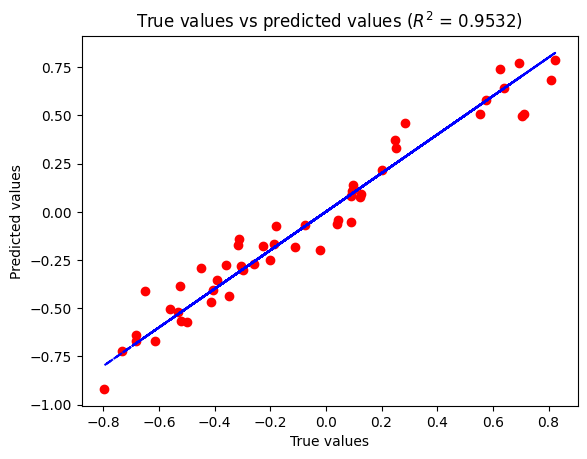

In [21]:
X_test, y_true_test = gen_synthetic_dataset(n_samples=50)
y_pred_test = lr.predict(X_test)
plot_prediction(y_true_test, y_pred_test)

# 参数惩罚与模型正则化

$\quad$为了缓解**过拟合**(overfitting)现象, 一种常用的策略是模型**正则化**(regularization): 在损失函数中添加参数的$L_2$-范数惩罚项，

$$
\tilde{\mathcal{L}} := \mathcal{L} + \alpha\|\mathbf{w}\|^2,
$$

其中, $\alpha$称为**正则化强度**(regularization strength), 控制着$\mathbf{w}\to\mathbf{0}$的倾向性. 理论课程已经讲过, 若参数先验和数据似然都取Gaussian分布的形式, 则$L_2$-正则化等价于**收缩参数的先验分布窗口**.

$\quad$带有$L_2$-正则化项的线性回归也称为**岭回归**(ridge regression), 在`sklearn`中以[`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn-linear-model-ridge)实现. 其中, 参数`alpha`即为正则化强度. 以下的代码构建一个$\alpha=10.0$的岭回归模型`lr_reg`, 并和`lr`模型以相同的训练集进行训练、在相同测试集上进行评估. 可见, 正则化在一定程度上会带来决定系数(准确度)的牺牲.

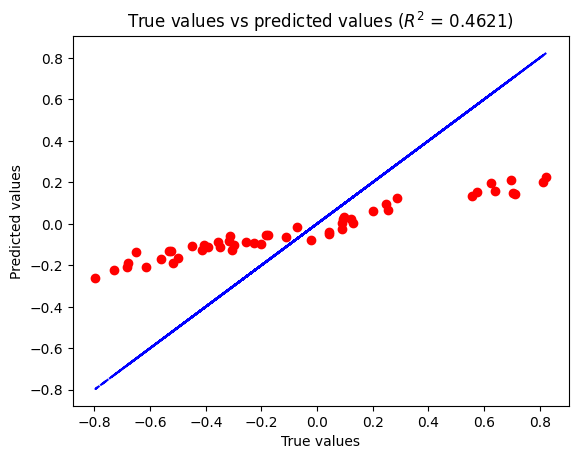

In [22]:
from sklearn.linear_model import Ridge
lr_reg = Ridge(alpha=10.0)
lr_reg.fit(X_train, y_true_train)
y_reg_pred_test = lr_reg.predict(X_test)
plot_prediction(y_true_test, y_reg_pred_test)

$\quad$模型正则化是一种较精细地调控模型复杂度的手法. 正则化强度越大, 模型容量、复杂度越低(预测能力会打一些折扣), 但相应地会提升泛化能力和稳定性. 以下取$\alpha = 10^{-3}, 10^{-2}, 10^{-1}, 10^0, 10^1, 10^2, 10^3$, 分别构建并训练模型, 给出训练集与测试集上的**根均方误差**(RMSE), 以及二者的差值(称为**泛化间隔**, generalization gap), 以作比较. 为了突出过拟合现象, 我们重新构造只含4个样本的训练集.

In [23]:
X_train, y_true_train = gen_synthetic_dataset(n_samples=4)

In [24]:
from sklearn.metrics import root_mean_squared_error as RMSE

rmse_train, rmse_test, rmse_gap = [], [], []
alphas = (1e-3, 1e-2, 1e-1, 1, 10, 100, 1000)
for alpha in alphas:
    lr_reg = Ridge(alpha=alpha).fit(X_train, y_true_train)
    y_pred_train = lr_reg.predict(X_train)
    y_pred_test = lr_reg.predict(X_test)
    rmse_train.append(RMSE(y_true_train, y_pred_train))
    rmse_test.append(RMSE(y_true_test, y_pred_test))
    rmse_gap.append(abs(rmse_test[-1] - rmse_train[-1]))

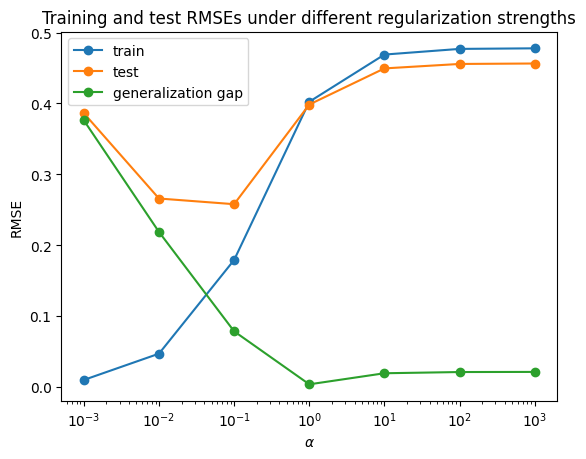

In [25]:
from matplotlib import pyplot as plt

plt.title("Training and test RMSEs under different regularization strengths")
plt.xlabel(r"$\alpha$")
plt.xscale("log")
plt.ylabel("RMSE")
plt.plot(alphas, rmse_train, marker="o", label="train")
plt.plot(alphas, rmse_test, marker="o", label="test")
plt.plot(alphas, rmse_gap, marker="o", label="generalization gap")
plt.legend()
plt.show()

$\quad$正则化强度$\alpha$是模型的超参数. 以上的过程是一个简单的**超参数搜索**(hyperparameter searching)的例子.
- 随着$\alpha$的升高, 测试误差和泛化间隔都呈现“先降后升”的趋势. 当$\alpha \to +\infty$时, 泛化间隔趋于零, 因为训练与测试做得“一样糟糕”.
- 在本例中, 测试误差在$\alpha = 0.1$时达到最低, 泛化间隔在$\alpha = 1.0$时达到最低, 大家可以根据问题实际来选择最终的模型超参数取值. 